<a href="https://colab.research.google.com/github/andreacini/ml-19-20/blob/master/XX_nn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning 

Prof. Cesare Alippi   
Andrea Cini ([`andrea.cini@usi.ch`](mailto:andrea.cini@usi.ch))   
Daniele Zambon ([`daniele.zambon@usi.ch`](mailto:daniele.zambon@usi.ch))   

---

# Training a neural network

In [0]:
%tensorflow_version 2.x
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython import display
from tqdm import tqdm
from sklearn.datasets import make_moons, make_circles, make_classification
import time

# color_maps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

## 1. Regression problem

In [0]:
def get_data(rang, sigma):
    """ Generate data for regression. """
    x_true = np.linspace(*rang, 1000)
    y_true = g(x_true)

    # Random data
    x_data = np.random.rand(N)*(rang[1] - rang[0]) + rang[0]
    noise = np.random.randn(N)*sigma
    y_data = g(x_data) + noise

    # normalization
    xmu = x_data.mean()
    xstd = x_data.std() 
    normalize = lambda x: (x-xmu)/xstd
    return x_true, y_true, x_data, y_data, normalize

def get_regressor(neurons, patience):
    """ Generate the regressive model. """
    inp = keras.Input((1,))
    hid1 = keras.layers.Dense(neurons, activation="tanh")(inp)
    # hid2 = keras.layers.Dense(10, activation="tanh")(hid1)
    out = keras.layers.Dense(1, activation="linear")(hid1)
    model = keras.Model(inp, out)
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())
    es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=patience)
    return model, es

def run_regression_demo(rang, sigma, neurons, patience):
    """ Run the demo. """
    #get data
    x_true, y_true, x_data, y_data, normalize = get_data(rang=rang, sigma=sigma)
    x_train, y_train = normalize(x_data), y_data
    #get model
    model, es = get_regressor(neurons=neurons, patience=patience)

    #init figure
    fig = plt.figure()
    ax = fig.gca()
    #fixed plots
    ax.plot(x_true, g(x_true), c="r", label="g(x)")
    ax.scatter(x_data, y_data, c="k", label="data")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim([rang[0]*.9, rang[1]*1.1])
    ax.set_ylim([min([0, y_data.min()])-.1, min([.6, y_data.max()+.1])])
    y_pred = model.predict(normalize(x_true))
    line=ax.plot(x_true, y_pred, c="g", label="NN(x)")[0]
    ax.legend(loc='upper right')
    display.display(plt.gcf(), display_id=40)

    #cycle training
    niter = int(EPOCHS_MAX/epochs_per_iter)
    for i in tqdm(range(niter),disable=True):
        # train
        history = model.fit(x_train, y_train, epochs=epochs_per_iter, callbacks=[es], verbose=0)
        y_pred = model.predict(normalize(x_true))

        # update plot
        line.set_ydata(y_pred)   
        ax.set_title("seed: {} | epochs: {}/{}".format(seed,
                                            epochs_per_iter*i+len(history.history["loss"]), 
                                            epochs_per_iter*niter))   
        display.update_display(plt.gcf(), display_id=40)

        # early stopping
        if len(history.history["loss"]) < epochs_per_iter:
            break      

Here you can play with the parameters

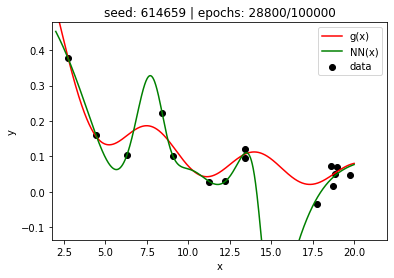

In [0]:
# Regression problem
N = 15                 # num datapoints
SIGMA = 0.03           # noise std
RANGE = [2., 20.]      # range of function g(x)
def g(x):              # true function
    return (x**2) / (x**3 + 1) + np.sin(x) / (x+10)

# Regressor
NEURONS = 5            # num neurons
PATIENCE = 40          # patience early stopping
EPOCHS_MAX = 1e5       # max num training epochs

# Plot
epochs_per_iter = 400  # update plot every...

#seed = 42
seed = np.random.randint(1000000)
np.random.seed(seed)
run_regression_demo(rang=RANGE, sigma=SIGMA, neurons=NEURONS, patience=PATIENCE)

## 2. Classification problem

In [0]:
def make_spirals(n_points, noise=.01):
    """
     Returns the two spirals dataset.
     from:https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 500 * (2*np.pi)/360
    d1x = - np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))
    
def get_classifier(neurons, patience):
    inp = keras.Input((2,))
    hid1 = keras.layers.Dense(neurons, activation="tanh")(inp)
    hid2 = keras.layers.Dense(neurons, activation="tanh")(hid1)
    out = keras.layers.Dense(1, activation="sigmoid")(hid1)
    model = keras.Model(inp, out)
    model.compile(loss=keras.losses.BinaryCrossentropy(), 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=patience)
    return model, es
            
def run_classification_demo():
    if TYPE == 'circles':
        data_gen = lambda: make_circles(N, noise=NOISE, factor=0.5)
    elif TYPE == 'moons':
        data_gen = lambda : make_moons(N, noise=NOISE)
    elif TYPE == 'simple':
        def data_gen():
            X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)
            X += NOISE * 10 * np.random.uniform(size=X.shape)
            return (X, y)
    elif TYPE == 'spirals':
        data_gen = lambda : make_spirals(N, NOISE)
    
    X, y = data_gen()
    normalize = lambda x: (x- x.mean(axis=0, keepdims=True))/x.std(axis=0, keepdims=True)
    
    X = normalize(X)
    
    #get model
    model, es = get_classifier(neurons=NEURONS, patience=PATIENCE)
    
    #init figure
    fig = plt.figure()
    ax = fig.gca()

    # Create mesh
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # plot train data
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    
    y_pred = y_pred.reshape(xx.shape)
    surface = ax.contourf(xx, yy, y_pred, levels=np.linspace(0,1,8), cmap=cm, alpha=.8)
    cbar = fig.colorbar(surface, ax=ax)
    
    display.display(plt.gcf(), display_id=42)

    #cycle training
    niter = int(EPOCHS_MAX/epochs_per_iter)
    for i in tqdm(range(niter),disable=True):
        # train
        history = model.fit(X, y, epochs=epochs_per_iter, callbacks=[es], verbose=0)
        y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        y_pred = y_pred.reshape(xx.shape)
        
        for coll in surface.collections: 
            plt.gca().collections.remove(coll) 
        surface = ax.contourf(xx, yy, y_pred, cmap=cm, alpha=.8)

        ax.set_title("seed: {} | epochs: {}/{}".format(seed,
                                           epochs_per_iter*i+len(history.history["loss"]), 
                                           epochs_per_iter*niter))   
        display.update_display(plt.gcf(), display_id=42)

        # early stopping
        if len(history.history["loss"]) < epochs_per_iter:
            break


Here you can play with the parameters

In [0]:
# Classification problem
N = 100                 # num datapoints
NOISE = 0.1             # noise
TYPE = 'circles'        # choose between 'circles', 'moons', 'spirals', 'simple'

# Classifier
NEURONS = 20           # num neurons
PATIENCE = 40          # patience early stopping
EPOCHS_MAX = 4000      # max num training epochs
# Plot
epochs_per_iter = 50  # update plot every...

seed = 100
np.random.seed(seed)
run_classification_demo()